Populating the interactive namespace from numpy and matplotlib
1.99999999588
Simulation finished in 0:00:03.                                                 


c:\users\aaron\appdata\local\enthought\canopy\user\lib\site-packages\scipy\signal\filter_design.py:1057: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


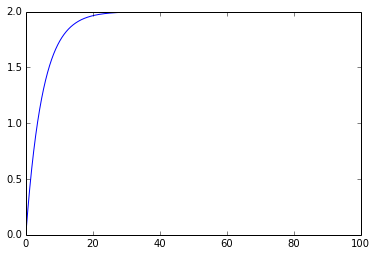

In [1]:
%pylab inline

import numpy as np
import nengo
import nengolib

print nengolib.signal.cont2discrete(2*nengolib.Lowpass(5.0), dt=100).gain

with nengo.Network() as model:
    stim = nengo.Node(output=[2])
    p = nengo.Probe(stim, synapse=5.0)
    
sim = nengo.Simulator(model)
sim.run(100)

#print sim.data[p]

pylab.figure()
pylab.plot(sim.trange(), sim.data[p])
pylab.show()

In [24]:
import warnings

import numpy as np
from numpy.linalg import cond
from scipy.linalg import solve_lyapunov, eig, inv
from scipy.optimize import fminbound

#from nengolib.signal.reduction import hankel
from nengolib.signal.discrete import impulse, cont2discrete
from nengolib.signal.system import LinearSystem


def _state_impulse(A, x0, k, delay=0):
    """Computes the states for discrete feedback A starting from x0."""
    x = np.zeros((k, len(A)))
    x[delay, :] = np.squeeze(x0)
    for i in range(delay+1, k):
        x[i, :] = np.dot(A, x[i-1, :])  # note: doesn't assume canonical form
    return x


def l1_norm(sys, rtol=1e-6, max_length=2**18):
    """Returns the L1-norm of a linear system within a relative tolerance.

    The L1-norm of a (BIBO stable) linear system is the integral of the
    absolute value of its impulse response. For unstable systems this will be
    infinite. The L1-norm is important because it bounds the worst-case
    output of the system for arbitrary inputs within [-1, 1]. In fact,
    this worst-case output is achieved by reversing the input which alternates
    between -1 and 1 during the intervals where the impulse response is
    negative or positive, respectively (in the limit as T -> infinity).

    Algorithm adapted from [1]_ following the methods of [2]_. This works by
    iteratively refining lower and upper bounds using progressively longer
    simulations and smaller timesteps. The lower bound is given by the
    absolute values of the discretized response. The upper bound is given by
    refining the time-step intervals where zero-crossings may have occurred.

    References:
        [1] http://www.mathworks.com/matlabcentral/fileexchange/41587-system-l1-norm/content/l1norm.m  # noqa: E501
            J.F. Whidborne (April 28, 1995).

        [2] Rutland, Neil K., and Paul G. Lane. "Computing the 1-norm of the
            impulse response of linear time-invariant systems."
            Systems & control letters 26.3 (1995): 211-221.
    """
    sys = LinearSystem(sys)
    if not sys.analog:
        raise ValueError("system (%s) must be analog" % sys)

    # Setup state-space system and check stability/conditioning
    A, B, C, D = sys.ss
    alpha = np.max(eig(A)[0].real)  # eq (28)
    if alpha > 0:
        raise ValueError("system (%s) has unstable eigenvalue: %s" % (
            sys, alpha))

    # Compute a suitable lower-bound for the L1-norm
    # using the steady state response, which is equivalent to the
    # L1-norm without an absolute value (i.e. just an integral)
    G0 = np.dot(-C, np.dot(inv(A), B))

    # Compute a suitable upper-bound for the L1-norm
    # Note this should be tighter than 2*sum(abs(hankel(sys)))
    def _normtail(sig, A, x, C):
        # observability gramiam when A perturbed by sig
        W = solve_lyapunov(A.T + sig*np.eye(len(A)), -C.T.dot(C))
        return np.sqrt(x.dot(W).dot(x.T) / 2 / sig)  # eq (39)

    xtol = -alpha * 1e-4
    _, fopt, _, _ = fminbound(
        _normtail, 0, -alpha, (A, B.T, C), xtol=xtol, full_output=True)

    # Setup parameters for iterative optimization
    L, U = abs(G0), fopt
    N = 2**4
    T = -1 / alpha

    while N <= max_length and .5 * (U - L) / L >= rtol:  # eq (25)

        # Step 1. Improve the lower bound by simulating more.
        dt = T / N
        dsys = cont2discrete(sys, dt=dt)
        Phi = dsys.A

        y = impulse(dsys, dt=None, length=N)
        abs_y = abs(y[1:])
        L_impulse = np.sum(abs_y)

        # bound the missing response from t > T from below
        L_tail = abs(G0 - np.sum(y))  # eq (33)
        L = max(L, L_impulse + L_tail)

        # Step 2. Improve the upper bound using refined interval method.
        x = _state_impulse(Phi, x0=B, k=N, delay=0)  # eq (38)
        abs_e = np.squeeze(abs(C.dot(x.T)))
        x = x[:-1]

        # find intervals that could have zero-crossings and adjust their
        # upper bounds (the lower bound is exact for the other intervals)
        CTC = C.T.dot(C)
        W = solve_lyapunov(A.T, Phi.T.dot(CTC).dot(Phi) - CTC)  # eq (36)
        AWA = A.T.dot(W.dot(A))
        thresh = np.squeeze(  # eq (41)
            np.sqrt(dt * np.sum(x.dot(AWA) * x, axis=1)))
        cross = np.maximum(abs_e[:-1], abs_e[1:]) <= thresh  # eq (20)
        abs_y[cross] = np.sqrt(  # eq (22, 37)
           dt * np.sum(x[cross].dot(W) * x[cross], axis=1))

        # bound the missing response from t > T from above
        _, U_tail, _, _ = fminbound(
            _normtail, 0, -alpha, (A, x[-1], C), xtol=xtol, full_output=True)
        U_impulse = np.sum(abs_y)
        U = max(min(U, U_impulse + U_tail), L)

        N *= 2
        if U_impulse - L_impulse <  U_tail - L_tail:  # eq (26)
            T *= 2

    return (U + L) / 2, .5 * (U - L) / L
    

from nengolib.synapses.analog import Alpha, Lowpass, Bandpass, PadeDelay

sys = Lowpass(0.1) + Lowpass(0.2)  # Bandpass(50, 5)
print l1_norm(sys)

(array([[ 2.]]), array([[  1.93150984e-09]]))


1.99999245668 1.99999245668 [[ 2.]] [[  7.54332379e-06]]


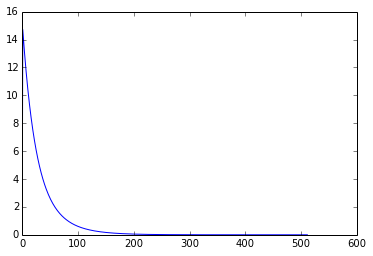

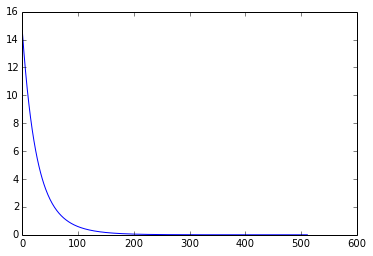

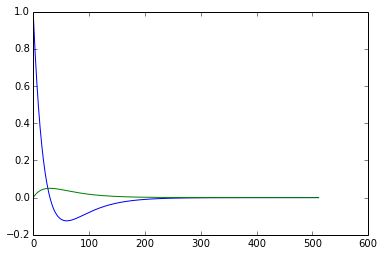

[  1.47421865e-06   1.99997052e-02]


In [25]:
import nengolib

#sys = Lowpass(0.01) - 1.5 * Lowpass(0.2)
dt = .00461638170137
N = 512    
dsys = nengolib.signal.cont2discrete(sys, dt=dt)
A, B, C, D = sys.ss
Phi, Gamma = dsys.A, dsys.B
y = impulse(dsys, dt=None, length=N)
nu_l_k = abs(y[1:])
sum_nu_l_k = sum(nu_l_k)
G0 = np.dot(-C, np.dot(inv(A), B))
print sum_nu_l_k, np.sum(y), G0, abs(G0 - np.sum(y)) 


pylab.figure()
pylab.plot(nengolib.signal.impulse(sys, dt=dt, length=N))
pylab.show()

pylab.figure()
pylab.plot(np.dot(_state_impulse(Phi, Gamma, N), C.T) / dt)
pylab.show()

pylab.figure()
pylab.plot(_state_impulse(Phi, Gamma, N) / dt)
pylab.show()

print np.sum(_state_impulse(Phi, Gamma, N), axis=0)

In [ ]:
print np.maximum([2, 0, 4], [1, 2, 3]) <= np.array([4, 1, 5])